# Import libraries

In [1]:
import boto3
import pandas as pd
import numpy as np
import io
from sagemaker import get_execution_role
import os

# Amazon SageMaker Python SDK
import sagemaker.amazon.common as smac 
import sagemaker

# instruction to Jupyter to inline all the visualizations
%matplotlib inline 

# Data Ingestion

Next, we read the dataset from an online URL into memory, for preprocessing prior to training.

In [2]:
role = get_execution_role()
input_bucket = 'aws-reinvent-kesha'
in_data_key = 'crime-data.csv'
training_data_location = 's3://{}/{}'.format(input_bucket, in_data_key)

# Define the headers since the data does not have any
headers = ['CommittedCrime','County','TimeofDay','DayofWeek','Month','Gender','AverageAge']

df = pd.read_csv(training_data_location, names=headers)
print('uploaded training data from location: {}'.format(training_data_location))

uploaded training data from location: s3://aws-reinvent-kesha/crime-data.csv


# Data Inspection & Visualization

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed.

In [3]:
#inspect the data
df.head()

,CommittedCrime,County,TimeofDay,DayofWeek,Month,Gender,AverageAge
0,1,DevonCornwall,morning,Sunday,January,Male,48.0
1,1,DevonCornwall,afternoon,Sunday,January,Male,21.0
2,1,DevonCornwall,morning,Thursday,January,Male,30.0
3,1,DevonCornwall,morning,Thursday,January,Female,48.0
4,1,DevonCornwall,afternoon,Friday,January,Female,30.0


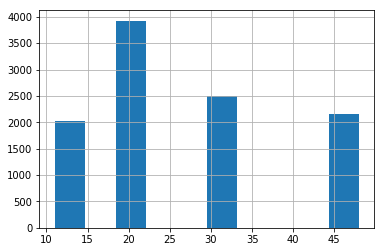

In [4]:
df.AverageAge.hist()

In [5]:
#look at relationship among different columns
#this shows the count of each county by committed crime
#So for Kent, 235 records where no crime and 365 records where there is crime
#So for Surrey, 437 no crime, 473 crime
pd.crosstab(df.County,df.CommittedCrime)

CommittedCrime,0,1
County,,
DevonCornwall,776,423
Dorset,259,143
Essex,762,427
Hampshire,1621,1992
Kent,1401,1551
Nottinghamshire,235,365
Surrey,437,473


In [6]:
pd.crosstab(df.Gender,df.CommittedCrime)

CommittedCrime,0,1
Gender,,
Female,649,589
Male,4724,4715
Other,16,13


# Data Cleaning

Get rid of null or bad values

In [7]:
#Records that need to be removed because they are null or empty
df.isnull().sum()

CommittedCrime      0
County              0
TimeofDay           0
DayofWeek           0
Month               0
Gender            159
AverageAge        272
dtype: int64

In [8]:
#REMOVE AGE RECORDS THAT ARE NaN
df.dropna(subset=['AverageAge'], inplace=True)

#double check to see removed
df['AverageAge'].isnull().sum()

0

In [9]:
#Remove the null records for Gender
df.dropna(subset=['Gender'], inplace=True)

#double check to see removed
df['Gender'].isnull().sum()

0

In [10]:
#Remove the records that are 'Other' for Gender
#NOTE: Make sure to assign back the updated data frame
df = df[df.Gender != 'Other']

# Data Encoding & Transformation

Before you start training, you first need to prepare the data because classifiers only work with numerical values. Let's convert the categorical features into numeric features. 

In [11]:
#check to see the data types we have
df.dtypes

CommittedCrime      int64
County             object
TimeofDay          object
DayofWeek          object
Month              object
Gender             object
AverageAge        float64
dtype: object

In [12]:
#Use "find and replace" method to convert text to string
#Day of Week is easily translated to valid numbers - Monday is 1, Tuesday is 2, Wednesday is 3.....
#Month is easily translated to valid numbers - January is 1, February 2, March is 3 ......
#Gender is easily translated to valid numbers - 1 is Male, 2 is Female
convert_nums = {"DayofWeek": {"Monday": 1, 
                              "Tuesday": 2,
                              "Wednesday": 3,
                              "Thursday": 4,
                              "Friday": 5,
                              "Saturday": 6,
                              "Sunday": 7},
                "Month": {"January": 1, 
                          "February": 2, 
                          "March": 3, 
                          "April": 4,
                          "May": 5, 
                          "June": 6, 
                          "July": 7, 
                          "August": 8, 
                          "September": 9, 
                          "October": 10, 
                          "November": 11, 
                          "December": 12}}

#convert the columns to numbers using replace
train_df = df.copy()
train_df.replace(convert_nums, inplace=True)
train_df.head()

,CommittedCrime,County,TimeofDay,DayofWeek,Month,Gender,AverageAge
0,1,DevonCornwall,morning,7,1,Male,48.0
1,1,DevonCornwall,afternoon,7,1,Male,21.0
2,1,DevonCornwall,morning,4,1,Male,30.0
3,1,DevonCornwall,morning,4,1,Female,48.0
4,1,DevonCornwall,afternoon,5,1,Female,30.0


In [13]:
#Use "One Hot Encoding" method on values that can't be easily translated to a numeric value
#Convert each category value into a new column and assigns a 1 or 0 (True/False) value to the column. 
#This has the benefit of not weighting a value improperly but does add more columns to the data set.
#Pandas supports this feature using get_dummies. This function is named this way because 
#it creates dummy/indicator variables (aka 1 or 0)


#List all the unique values for Gender
train_df.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [14]:
#Convert using get_dummies; goes from 1 column to 2 with a 1 or 0 corresponding to the correct value
train_df = pd.get_dummies(train_df, columns=["Gender"])
train_df.head()

,CommittedCrime,County,TimeofDay,DayofWeek,Month,AverageAge,Gender_Female,Gender_Male
0,1,DevonCornwall,morning,7,1,48.0,0,1
1,1,DevonCornwall,afternoon,7,1,21.0,0,1
2,1,DevonCornwall,morning,4,1,30.0,0,1
3,1,DevonCornwall,morning,4,1,48.0,1,0
4,1,DevonCornwall,afternoon,5,1,30.0,1,0


In [15]:
#Convert using get_dummies; goes from 1 column to 3 with a 1 or 0 corresponding to the correct value
train_df = pd.get_dummies(train_df, columns=["TimeofDay"])

In [16]:
#Convert using get_dummies; goes from 1 column to 7 with a 1 or 0 corresponding to the correct value
train_df = pd.get_dummies(train_df, columns=["County"])

In [17]:
train_df.head()

,CommittedCrime,DayofWeek,Month,AverageAge,Gender_Female,Gender_Male,TimeofDay_afternoon,TimeofDay_evening,TimeofDay_morning,County_DevonCornwall,County_Dorset,County_Essex,County_Hampshire,County_Kent,County_Nottinghamshire,County_Surrey
0,1,7,1,48.0,0,1,0,0,1,1,0,0,0,0,0,0
1,1,7,1,21.0,0,1,1,0,0,1,0,0,0,0,0,0
2,1,4,1,30.0,0,1,0,0,1,1,0,0,0,0,0,0
3,1,4,1,48.0,1,0,0,0,1,1,0,0,0,0,0,0
4,1,5,1,30.0,1,0,1,0,0,1,0,0,0,0,0,0


# Splitting into Training, Validation, and Test Sets
This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [18]:
# convert dataframe to csv; save the original cleaned file to notebook instance
train_df.to_csv('crime-data-cleaned.csv', header=False, index=False)

# Split the data for training, validation, and test into separate dataframes
# produces a 60%, 20%, 20% split for training, validation and test sets
train_data, validation_data, test_data = np.split(train_df.sample(frac=1), [int(.6*len(train_df)), int(.8*len(train_df))])

#convert dfs to .csv and save locally; file is saved to notebook instance
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

# Upload Training Data to S3
Now that we've created our CSV files, we'll need to upload them to S3, so that Amazon SageMaker training can use it.

In [19]:
# load files to S3
# The S3 bucket, prefix, and file name that you want to use for training and model data 
output_bucket = 'aws-reinvent-kesha'
prefix = 'cleaned'

boto3.resource('s3').Bucket(output_bucket).Object(os.path.join(prefix, 'crime-data-cleaned.csv')).upload_file('crime-data-cleaned.csv')
boto3.resource('s3').Bucket(output_bucket).Object(os.path.join(prefix, 'train.csv')).upload_file('train.csv')
boto3.resource('s3').Bucket(output_bucket).Object(os.path.join(prefix, 'validation.csv')).upload_file('validation.csv')
boto3.resource('s3').Bucket(output_bucket).Object(os.path.join(prefix, 'test.csv')).upload_file('test.csv')

# Training the linear model

In [20]:
# specify containers
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

Next we'll kick off the base estimator, making sure to pass in the necessary hyperparameters. Notice:

feature_dim is set to 15, predictor_type is set to 'binary_classifier' since we are trying to predict whether the image is or is not a 0, epochs is 15, mini_batch_size is set to 200. This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.

In [31]:
import boto3
import sagemaker

sess = sagemaker.Session()
artificat_output_location = 's3://{}/{}/output'.format(output_bucket, prefix)

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=artificat_output_location,
                                       sagemaker_session=sess)

#linear.content_type = 

linear.set_hyperparameters(feature_dim=15,
                           epochs=15,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

s3_train_file = 's3://{}/{}/'.format(output_bucket, prefix, 'train.csv')
train_data_file = sagemaker.s3_input(s3_data=s3_train_file, content_type='text/csv')
linear.fit({'train': train_data_file})

2020-06-06 01:35:30 Starting - Starting the training job...
2020-06-06 01:35:32 Starting - Launching requested ML instances.........
2020-06-06 01:37:15 Starting - Preparing the instances for training.........
2020-06-06 01:38:51 Downloading - Downloading input data...
2020-06-06 01:39:29 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/06/2020 01:39:32 INFO 140303090759488] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6064014165969122, "sum": 0.6064014165969122, "min": 0.6064014165969122}}, "EndTime": 1591407579.618612, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1591407579.618553}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6031359955923898, "sum": 0.6031359955923898, "min": 0.6031359955923898}}, "EndTime": 1591407579.618686, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1591407579.618673}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.616700679960705, "sum": 0.616700679960705, "min": 0.616700679960705}}, "EndTime": 1591407579.618759, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner",

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.48261216831207276, "sum": 0.48261216831207276, "min": 0.48261216831207276}}, "EndTime": 1591407591.980735, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1591407591.980676}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.48092477717853727, "sum": 0.48092477717853727, "min": 0.48092477717853727}}, "EndTime": 1591407591.980825, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1591407591.980811}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4858628888357253, "sum": 0.4858628888357253, "min": 0.4858628888357253}}, "EndTime": 1591407591.980863, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear 

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.46119210967563445, "sum": 0.46119210967563445, "min": 0.46119210967563445}}, "EndTime": 1591407598.117028, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1591407598.116965}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.46330926943960643, "sum": 0.46330926943960643, "min": 0.46330926943960643}}, "EndTime": 1591407598.117104, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1591407598.117091}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4634543253580729, "sum": 0.4634543253580729, "min": 0.4634543253580729}}, "EndTime": 1591407598.117163, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear 

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4382194279829661, "sum": 0.4382194279829661, "min": 0.4382194279829661}}, "EndTime": 1591407610.472175, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1591407610.472115}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.446867571969827, "sum": 0.446867571969827, "min": 0.446867571969827}}, "EndTime": 1591407610.472246, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1591407610.472233}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4396134145600455, "sum": 0.4396134145600455, "min": 0.4396134145600455}}, "EndTime": 1591407610.472306, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner


2020-06-06 01:40:32 Uploading - Uploading generated training model
2020-06-06 01:40:32 Completed - Training job completed
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.43144562773477463, "sum": 0.43144562773477463, "min": 0.43144562773477463}}, "EndTime": 1591407616.668108, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1591407616.668049}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4427167815963427, "sum": 0.4427167815963427, "min": 0.4427167815963427}}, "EndTime": 1591407616.66818, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1591407616.668167}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4326245781240009, "sum": 0.4326245781240009, "min": 0.4326245781240009}}, 

Training seconds: 101
Billable seconds: 101


# Set up hosting for the model

In [33]:
linear_predictor = linear.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

-----------------!

# Validate the model for use

In [34]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [36]:
result = linear_predictor.predict([4,10,30,0,1,1,0,0,0,0,0,0,0,1,0])
print(result)

{'predictions': [{'score': 0.9725478887557983, 'predicted_label': 1.0}]}


# Delete the Endpoint

In [37]:
import sagemaker

sagemaker.Session().delete_endpoint(linear_predictor.endpoint)